<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: Galactic Science

## Goal

This notebook is a study of [ZTF18abktckv](https://fink-portal.org/ZTF18abktckv).

## Useful links

- API documentation: https://fink-portal.org/api
- Schema of Fink database: https://fink-portal.org/api/v1/columns
- CDS xmatch service: http://cdsxmatch.u-strasbg.fr/xmatch
- SIMBAD description of classes: http://simbad.u-strasbg.fr/simbad/sim-display?data=otypes
- LIA: https://github.com/dgodinez77/LIA

## Environment set up

To run this notebook, you need to import the following libraries (some are already installed in  colab):

In [1]:
# !pip install seaborn
# !pip install fink_science
# !pip install astropy
# !pip install pyLIMA

import io
import requests

import pandas as pd
import numpy as np

from fink_utils.photometry.conversion import dc_mag

from astropy.coordinates import SkyCoord

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels, microltoolbox
from pyLIMA.microloutputs import create_the_fake_telescopes

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_context('talk')

In [2]:
def estimateGaiaError(mag):
    """ Estimate Gaia error from magnitude
    """
    a1=0.2
    b1= -5.3#-5.2
    log_err1 = a1*mag + b1
    a2=0.2625
    b2= -6.3625#-6.2625
    log_err2 = a2*mag + b2

    if (mag<13.5): expectedStdAtBaselineMag = 10**(a1*13.5+b1)
    if (mag>=13.5 and mag<17) : expectedStdAtBaselineMag = 10**log_err1
    if (mag>=17) : expectedStdAtBaselineMag = 10**log_err2
    #this works until 21 mag.

    return expectedStdAtBaselineMag*1

def get_model(current_event, mjd=True):
    """ Get time and magnitude from fitted model
    """
    # Model
    results = current_event.fits[0]
    create_the_fake_telescopes(results, results.fit_results)

    telescope_ = results.event.fake_telescopes[0]

    flux_model = mulens_model.compute_the_microlensing_model(
        telescope_, results.model.compute_pyLIMA_parameters(results.fit_results)
    )[0]

    time = telescope_.lightcurve_flux[:, 0]
    magnitude = microltoolbox.flux_to_magnitude(flux_model)
    
    if mjd:
        time = np.array([t - 2400000.5 for t in time])
        
    # params = results.fit_results
    # print(params)

    return time, magnitude

# Case study: Gravitational microlensing 

We deployed a science module to find (early) gravitational microlensing events. The microlensing classification module is based on the Lens Identification Algorithm (LIA) presented in [Godines et al. (2019)](). In short, a Random Forest algorithm is trained with simulated light-curves similar in cadence and noise to the associated survey of interest (currently ZTF). Of course, we receive _alerts_ with limited photometry size (up to 30 days with ZTF), so the game is very challenging!

### Association criterion and rate

An event is considered as Microlensing candidate if the classifier simultaneously favoured microlensing in all available bands (`g`, `r`). In addition, we make a cut on the number of times the light of this event has varied (at 3 sigma) since the beginning of the survey. This last cut is here to removes variable stars with long-trend.

In [3]:
# Get all latests alerts associated to Microlensing
r = requests.post(
  'https://fink-portal.org/api/v1/latests',
  json={
    'class': 'Microlensing candidate',
    'n': '5000',
  }
)

# Format output in a DataFrame
pdf_mulens = pd.read_json(io.BytesIO(r.content))
print(len(pdf_mulens))

4924


We have currently over 4000 alerts of data flagged as Microlensing candidates. Let's see if they are associated to a known transient in SIMBAD:

In [4]:
pdf_mulens.groupby(by='d:cdsxmatch')['d:mulens'].count()

d:cdsxmatch
Fail           25
Fail 400        2
Fail 500       16
Fail 502        4
Fail 503       11
Fail 504       21
Galaxy         33
Transient      25
Unknown      4787
Name: d:mulens, dtype: int64

A priori no (`cdsxmatch = Unknown`). Note that `cdsxmatch = Fail` means we couldn't perform the crossmatch with SIMBAD in real time (downtime, or network error, or ...). We usually recompute it on a later time. 

In [5]:
len(pdf_mulens.groupby(by='i:objectId').count())

1606

### Closer look to a candidate

We could look at all candidates, but let's focus only on one promising candidate:

In [6]:
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': 'ZTF18abktckv',
    'withupperlim': 'True',
  }
)

# Format output in a DataFrame
pdf_mulens_single = pd.read_json(io.BytesIO(r.content))

This candidate is located far from the galactic plane:

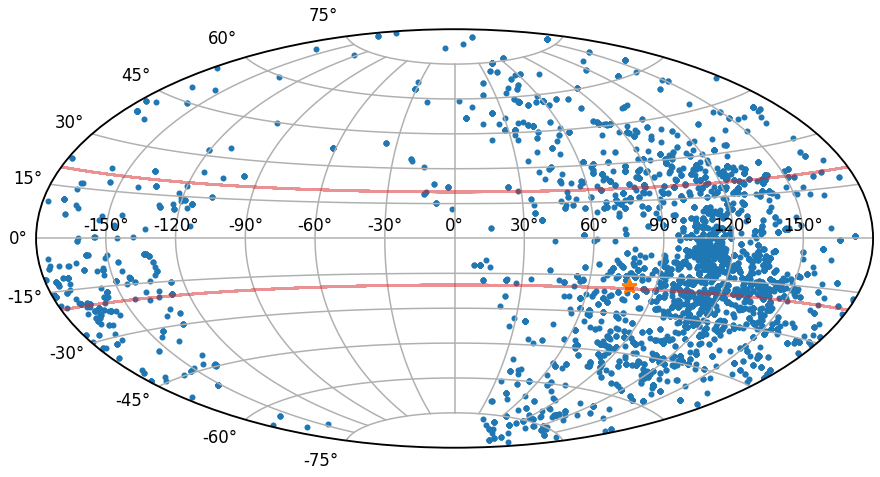

In [7]:
gal = SkyCoord(pdf_mulens['i:ra'], pdf_mulens['i:dec'], unit='deg').galactic

fig = plt.figure(figsize=(15, 10))

ax = plt.subplot(projection='aitoff')

plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, color='C0', alpha=1, marker='.')

# Add ZTF18abktckv
gal_single = SkyCoord(pdf_mulens_single['i:ra'], pdf_mulens_single['i:dec'], unit='deg').galactic
plt.scatter(
    gal_single.l.wrap_at('180d').radian, 
    gal_single.b.radian, color='C1', alpha=1, marker='*', s=200)

# Faking the region enclosing the galactic plane
x = np.arange(-180, 180, 0.1)
plt.plot(x, [20*np.pi/180]*len(x), color='C3', alpha=0.5)
plt.plot(x, [-20*np.pi/180]*len(x), color='C3', alpha=0.5)

plt.grid();

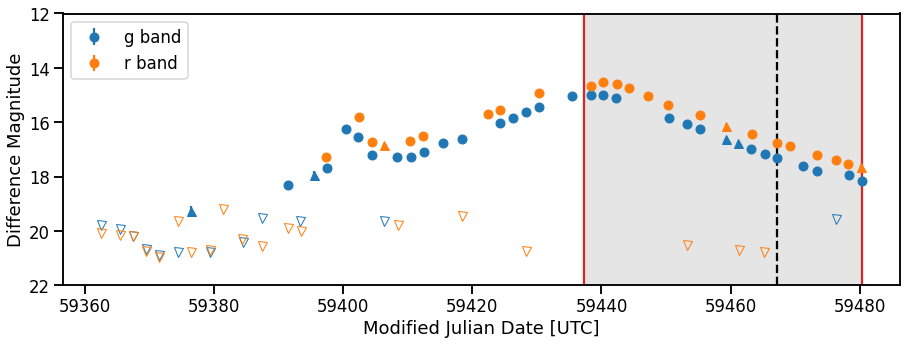

In [8]:
pdf_mulens_single = pdf_mulens_single.sort_values('i:jd')
mjd = pdf_mulens_single['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_mulens_single['i:fid']):
    maskFilt = pdf_mulens_single['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_mulens_single['d:tag'] == 'valid'
    plt.errorbar(
        pdf_mulens_single[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_mulens_single[maskValid & maskFilt]['i:magpsf'],
        pdf_mulens_single[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    maskUpper = pdf_mulens_single['d:tag'] == 'upperlim'
    plt.plot(
        pdf_mulens_single[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_mulens_single[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='v', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf_mulens_single['d:tag'] == 'badquality'
    plt.errorbar(
        pdf_mulens_single[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_mulens_single[maskBadquality & maskFilt]['i:magpsf'],
        pdf_mulens_single[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='^', color=colordic[filt]
    )
# Code might be shorter if we collect 'valid', 'upperquality' and 'badquality' into a single list (Petro)

    
# Highlight dates where it was flagged as an ML event
c0 = pdf_mulens_single['d:mulens'] > 0.0
jd0 = np.min(pdf_mulens_single[c0]['i:jd'].values)
minjd = np.min(pdf_mulens_single[c0]['i:jd'].values) - 30
maxjd = np.max(pdf_mulens_single[c0]['i:jd'].values)
plt.axvline(jd0 - 2400000.5, color='black', ls='--')
plt.axvline(minjd - 2400000.5, color='C3')
plt.axvline(maxjd - 2400000.5, color='C3')
plt.fill_betweenx([10, 25], minjd - 2400000.5, maxjd - 2400000.5, alpha=0.1, color='black')
# Why not convert all the dates at the beginning? (Petro)


plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
# plt.title(
#     'Object {}'.format(
#         pdf_mulens_single['i:objectId'].values[0]
#     )
# )
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');

_Circles (&#9679;) with error bars show valid alerts that pass the Fink quality cuts. Upper triangles with errors (&#9650;) represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by Fink science modules. Lower triangles (&#9661;) represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts._

The data in between the red lines is favoured as Microlensing by the classifier, and the first microlensing trigger is shown with the black line (recall alerts carry up to 30 days of history). On the Fink Science Portal, you can then try to extract Microlensing paramaters. The fit is done using [pyLIMA](https://github.com/ebachelet/pyLIMA) described in [Bachelet et al (2017)](https://ui.adsabs.harvard.edu/abs/2017AJ....154..203B/abstract). We used a simple PSPL model to fit the data. Here is a [link](https://fink-portal.org/ZTF18abktckv) in the portal for this event. Try pressing on "Microlensing" in upper right corner and "Fit data" on the right.

Let's try a different fit corresponding to Uniform-Source Binary Lens model:

In [9]:
dc_mag?

Signature:
dc_mag(
    magpsf: float,
    sigmapsf: float,
    magnr: float,
    sigmagnr: float,
    isdiffpos: int,
) -> Tuple[float, float]
Docstring:
Compute apparent magnitude from difference magnitude supplied by ZTF
Implemented according to p.107 of the ZTF Science Data System Explanatory Supplement
https://irsa.ipac.caltech.edu/data/ZTF/docs/ztf_explanatory_supplement.pdf

Parameters
----------
magpsf,sigmapsf
    magnitude from PSF-fit photometry, and 1-sigma error
magnr,sigmagnr
    magnitude of nearest source in reference image PSF-catalog
    within 30 arcsec and 1-sigma error
isdiffpos
    t or 1 => candidate is from positive (sci minus ref) subtraction
    f or 0 => candidate is from negative (ref minus sci) subtraction

Returns
--------
dc_mag: float
    Apparent magnitude
dc_sigmag: float
    Error on apparent magnitude
File:      ~/codes/fink-utils/fink_utils/photometry/conversion.py
Type:      function

In [10]:
# Take only valid measurements
pdf = pdf_mulens_single[pdf_mulens_single['d:tag'] == 'valid'].sort_values('i:jd', ascending=False)

# Use DC magnitude instead of difference mag
mag_dc, err_dc = np.transpose(
    [
        dc_mag(*args) for args in zip(
            pdf['i:magpsf'].astype(float).values,
            pdf['i:sigmapsf'].astype(float).values,
            pdf['i:magnr'].astype(float).values,
            pdf['i:sigmagnr'].astype(float).values,
            pdf['i:isdiffpos'].values
        )
    ]
)

# pyLIMA magic
current_event = event.Event()
current_event.name = pdf['i:objectId'].values[0]

current_event.ra = pdf['i:ra'].values[0]
current_event.dec = pdf['i:dec'].values[0]

filts = {1: 'g', 2: 'r'}
for fid in np.unique(pdf['i:fid'].values):
    mask = pdf['i:fid'].values == fid
    telescope = telescopes.Telescope(
        name='ztf_{}'.format(filts[fid]),
        camera_filter=format(filts[fid]),
        light_curve_magnitude=np.transpose(
            [
                pdf['i:jd'].values[mask],
                mag_dc[mask],
                err_dc[mask]
            ]
        ),
        light_curve_magnitude_dictionnary={
            'time': 0,
            'mag': 1,
            'err_mag': 2
        }
    )

    current_event.telescopes.append(telescope)

# USBL model
mulens_model = microlmodels.create_model('USBL', current_event)

# USBL is a 7 parameters model
mulens_model.parameters_guess = [
    2459438.8042624635, 0.28967950357242556, 
    28.54840874346009, 0.04989598439800191, 
    0.272393673849404, -2.8730822458911205, 
    0.23513925488422255-np.pi
] 

# Let's use the TRF method
current_event.fit(mulens_model, 'TRF')


Start fit on ZTF18abktckv, with model USBL and method TRF
check_event  : Everything looks fine, this event can be fitted
initial_guess  : Initial parameters guess SUCCESS
trust_region_reflective  : TRF fit SUCCESS
[2459438.987993148, 0.303312157931249, 28.97956613233972, 0.04825532757811771, 0.2699649895462718, -2.98846797097519, -2.903852412056545, 38510.562506068636, -0.003491735852231499, 57885.95644216283, 0.12434213162173255, 80.62880600230994]


In [11]:
# Number of degrees of freedom
dof = len(pdf) - len(mulens_model.parameters_guess) - 1

In [12]:
results = current_event.fits[0]

normalised_lightcurves = microltoolbox.align_the_data_to_the_reference_telescope(results, 0, results.fit_results)

# Model
create_the_fake_telescopes(results, results.fit_results)

telescope_ = results.event.fake_telescopes[0]

flux_model = mulens_model.compute_the_microlensing_model(telescope_, results.model.compute_pyLIMA_parameters(results.fit_results))[0]

time = telescope_.lightcurve_flux[:, 0]
magnitude = microltoolbox.flux_to_magnitude(flux_model)

Finally plot the fit on top of the (rescaled) measurements:

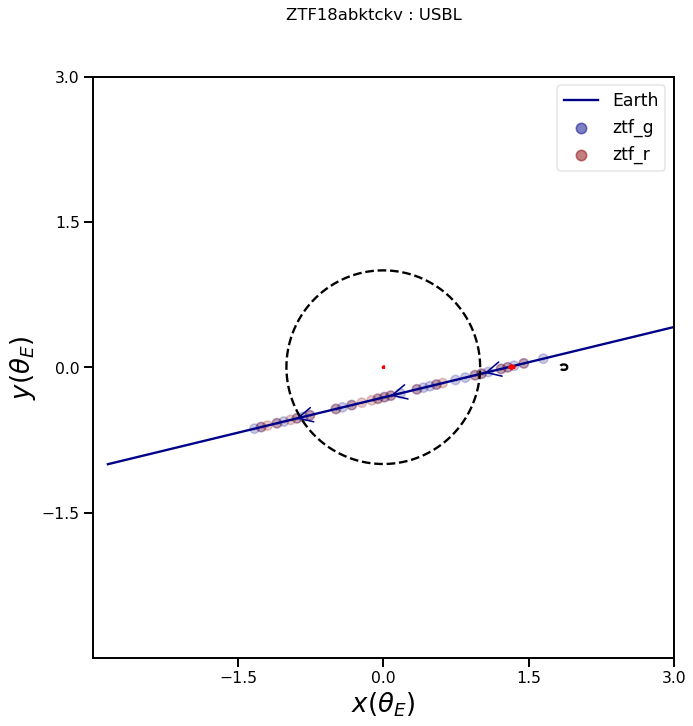

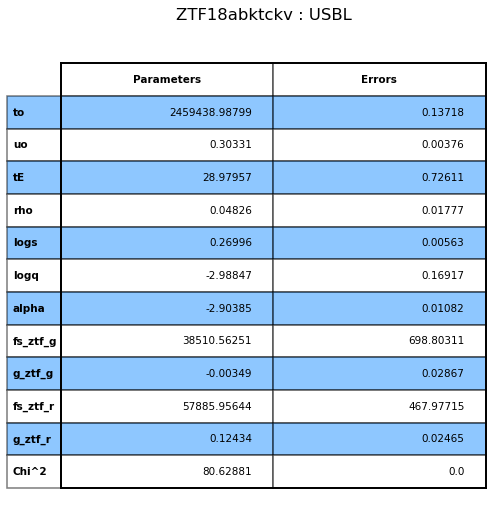

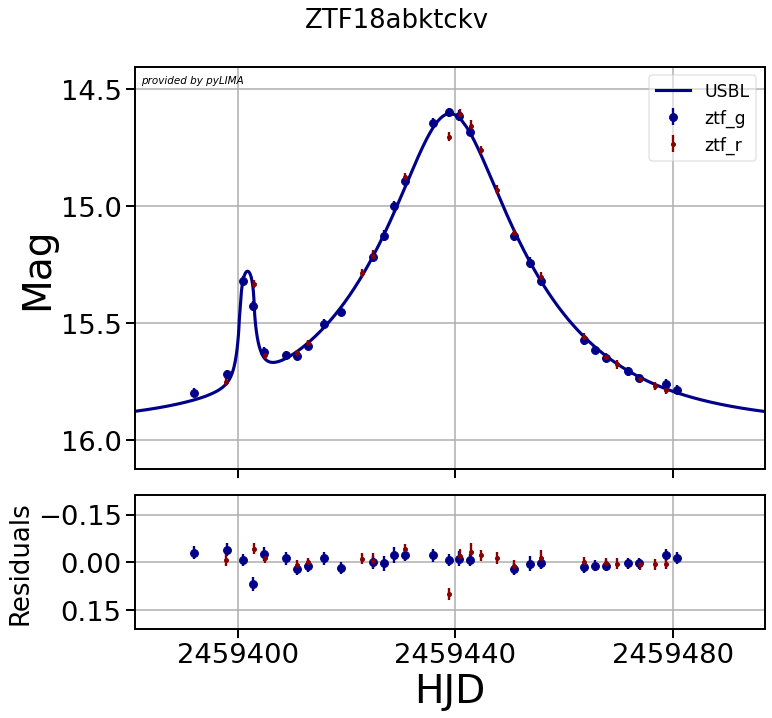

In [13]:
results.produce_outputs()
plt.show()

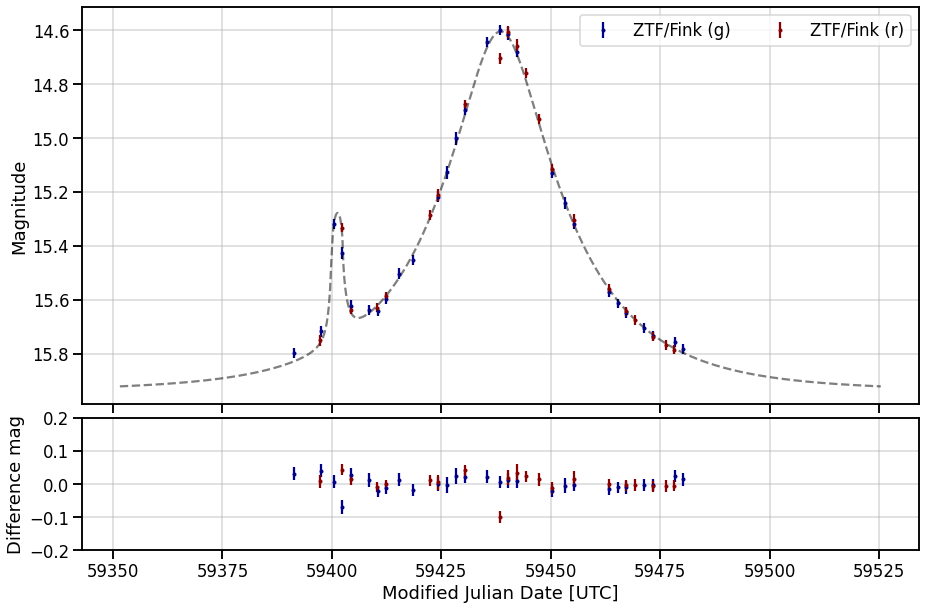

In [14]:
fig = plt.figure(figsize=(15, 10))

gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

name_telescopes = ['ZTF/Fink (g)', 'ZTF/Fink (r)']

for ax in [ax1]:
    for index, name in enumerate(name_telescopes):
        ax.errorbar(
            [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]],
            normalised_lightcurves[index][:, 1],
            normalised_lightcurves[index][:, 2],
            ls='',
            marker='o',
            markersize=3,
            label=name
        )

        if index == 0:
            ax.plot(
                *get_model(current_event),
                color='black', ls='--', alpha=0.5
            )
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('Magnitude');
ax1.invert_yaxis()
ax1.legend(ncol=2)
ax1.grid(alpha=0.5)

t_model, mag_model = get_model(current_event)
for index, name in enumerate(name_telescopes):
    mag_inter = np.interp(
        [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]], 
        t_model, 
        mag_model
    )
    ax2.errorbar(
        [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]],
        mag_inter - normalised_lightcurves[index][:, 1],
        normalised_lightcurves[index][:, 2],
        ls='',
        marker='o',
        markersize=3,
        label=name
    )

ax2.grid(alpha=0.5)
ax2.set_xlabel('Modified Julian Date [UTC]');
ax2.set_ylim(-0.2, 0.2)
ax2.set_ylabel('Difference mag');

In [15]:
# fitted parameters
names = results.model.model_dictionnary
params = results.fit_results
err = np.diag(np.sqrt(results.fit_covariance))

msg = """
# Fitted parameters
t0: {:.2f} +/- {:.2f} (MJD)
tE: {:.2f} +/- {:.2f} (days)
u0: {:.2f} +/- {:.2f}
rho: {:.2f} +/- {:.2f}
logs: {:.2f} +/- {:.2f}
logq: {:.2f} +/- {:.2f}
alpha: {:.2f} +/- {:.2f}
fs_ztf_g: {:.2f} +/- {:.2f}
g_ztf_g: {:.2f} +/- {:.2f}
fs_ztf_r: {:.2f} +/- {:.2f}
g_ztf_r: {:.2f} +/- {:.2f}
chi2/dof: {:.2f}
""".format(
    params[names['to']] - 2400000.5,
    err[names['to']],
    params[names['tE']],
    err[names['tE']],
    params[names['uo']],
    err[names['uo']],
    params[names['rho']],
    err[names['rho']],
    params[names['logs']],
    err[names['logs']],
    params[names['logq']],
    err[names['logq']],
    params[names['alpha']],
    err[names['alpha']],
    params[names['fs_ztf_g']],
    err[names['fs_ztf_g']],
    params[names['g_ztf_g']],
    err[names['g_ztf_g']],
    params[names['fs_ztf_r']],
    err[names['fs_ztf_r']],
    params[names['g_ztf_r']],
    err[names['g_ztf_r']],
    params[-1] / dof
)
print(msg)


# Fitted parameters
t0: 59438.49 +/- 0.14 (MJD)
tE: 28.98 +/- 0.73 (days)
u0: 0.30 +/- 0.00
rho: 0.05 +/- 0.02
logs: 0.27 +/- 0.01
logq: -2.99 +/- 0.17
alpha: -2.90 +/- 0.01
fs_ztf_g: 38510.56 +/- 698.80
g_ztf_g: -0.00 +/- 0.03
fs_ztf_r: 57885.96 +/- 467.98
g_ztf_r: 0.12 +/- 0.02
chi2/dof: 1.97



Not too bad - although we need much more data to conclude on the nature of the object ;-) We didn't have baseline but now we will take it from ZTF data.

### Inspecting the event using the full ZTF lightcurve

To futher check this event, we can query its data using the ZTF lightcurve API:

In [16]:
maskNone = pdf_mulens_single['d:tag'] == 'valid'
ra0 = np.mean(pdf_mulens_single[maskNone]['i:ra'].values)
dec0 = np.mean(pdf_mulens_single[maskNone]['i:dec'].values)

r = requests.post(
    'https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves', 
    data={'POS': 'CIRCLE {} {} 0.0004'.format(ra0, dec0), 
          'BAD_CATFLAGS_MASK': 32768, 
          'FORMAT': 'csv'
         }
)

pdf_ZTF = pd.read_csv(io.StringIO(r.text))

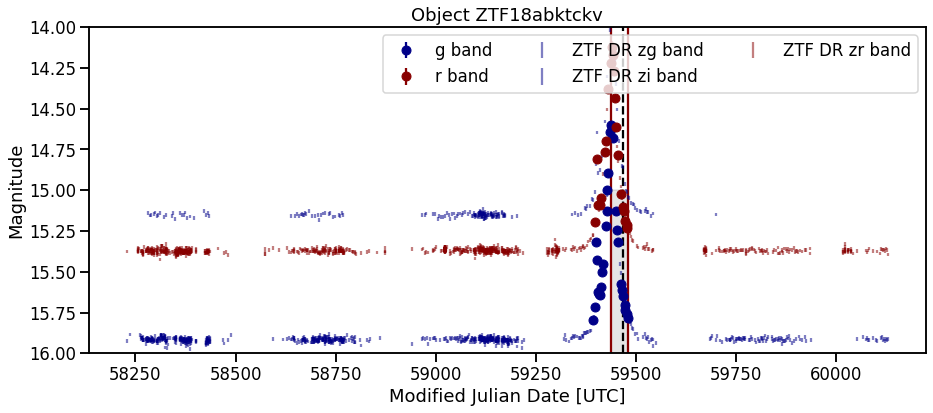

In [17]:
pdf_mulens_single = pdf_mulens_single.sort_values('i:jd')
mjd = pdf_mulens_single['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_mulens_single['i:fid']):
    maskFilt = pdf_mulens_single['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_mulens_single['d:tag'] == 'valid'
    
    # Use DC magnitude
    mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                pdf_mulens_single[maskValid & maskFilt]['i:magpsf'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:sigmapsf'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:magnr'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:sigmagnr'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:isdiffpos'].values
            )
        ]
    )

    
    plt.errorbar(
        pdf_mulens_single[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        mag_dc,
        err_dc,
        ls = '', marker='o', color=colordic[filt], 
        label='{} band'.format(filtdic[filt])
    )

    
# Highlight dates where it was flagged as an ML event
c0 = pdf_mulens_single['d:mulens'] > 0.0
jd0 = np.min(pdf_mulens_single[c0]['i:jd'].values)
minjd = np.min(pdf_mulens_single[c0]['i:jd'].values) - 30
maxjd = np.max(pdf_mulens_single[c0]['i:jd'].values)
plt.axvline(jd0 - 2400000.5, color='black', ls='--')
plt.axvline(minjd - 2400000.5, color='C3')
plt.axvline(maxjd - 2400000.5, color='C3')
plt.fill_betweenx([15, 25], minjd - 2400000.5, maxjd - 2400000.5, alpha=0.1, color='black')


colordic = {'zg': 'C0', 'zr': 'C1', 'zi': 'C2'}
for filt in np.unique(pdf_ZTF['filtercode']):
    maskFilt = pdf_ZTF['filtercode'] == filt
    plt.errorbar(
        pdf_ZTF[maskFilt]['mjd'], 
        pdf_ZTF[maskFilt]['mag'], 
        pdf_ZTF[maskFilt]['magerr'], 
        ls='', color=colordic[filt], alpha=0.5,
        label='ZTF DR {} band'.format(filt))

plt.ylim(16, 14)
#plt.gca().invert_yaxis()
plt.legend(ncol=3)
plt.title(
    'Object {}'.format(
        pdf_mulens_single['i:objectId'].values[0]
    )
)
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

Certainly not a variable star! Perfect!

Now we will test the model again but this time we will have the baseline.


Start fit on ZTF18abktckv, with model USBL and method TRF
check_event  : Everything looks fine, this event can be fitted
initial_guess  : Initial parameters guess SUCCESS
trust_region_reflective  : TRF fit SUCCESS
[2459438.8339372384, 0.2904106078775818, 28.559730843248033, 0.04991821311270513, 0.27258669341613, -2.8728000184977804, -2.906941213042617, 36264.00362936623, 0.08062546813501524, 57989.2199015958, 0.11707075581126525, 67878.91731814053, 0.1686150892132134, 52724.05365402561, 0.11295558848333752, 2901.1125663726903]


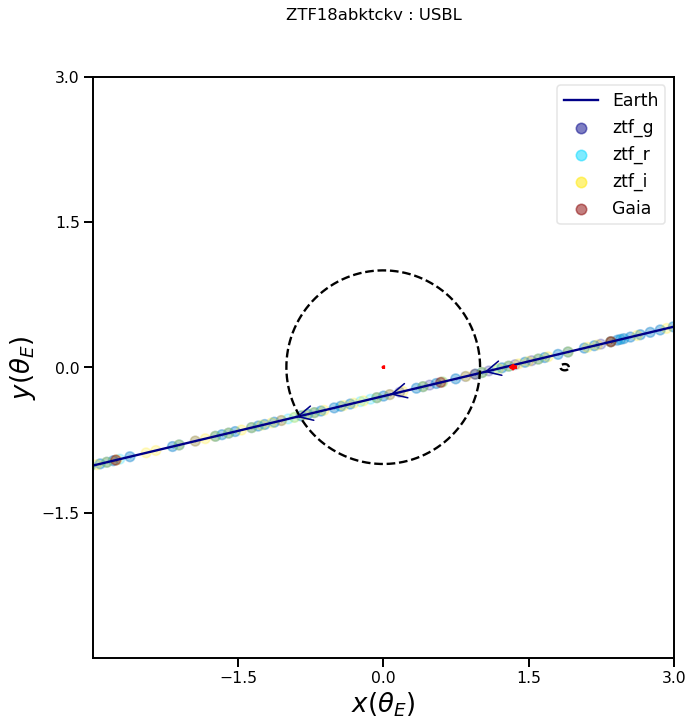

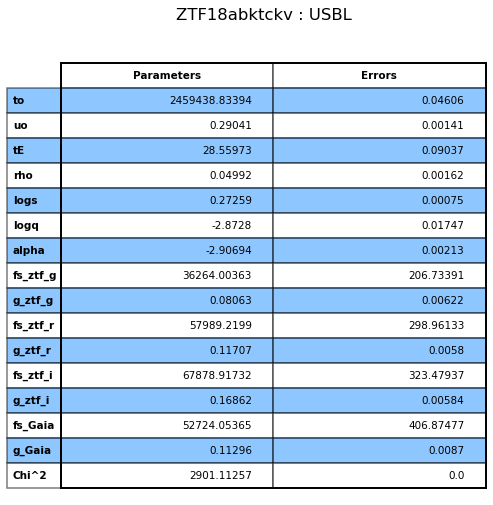

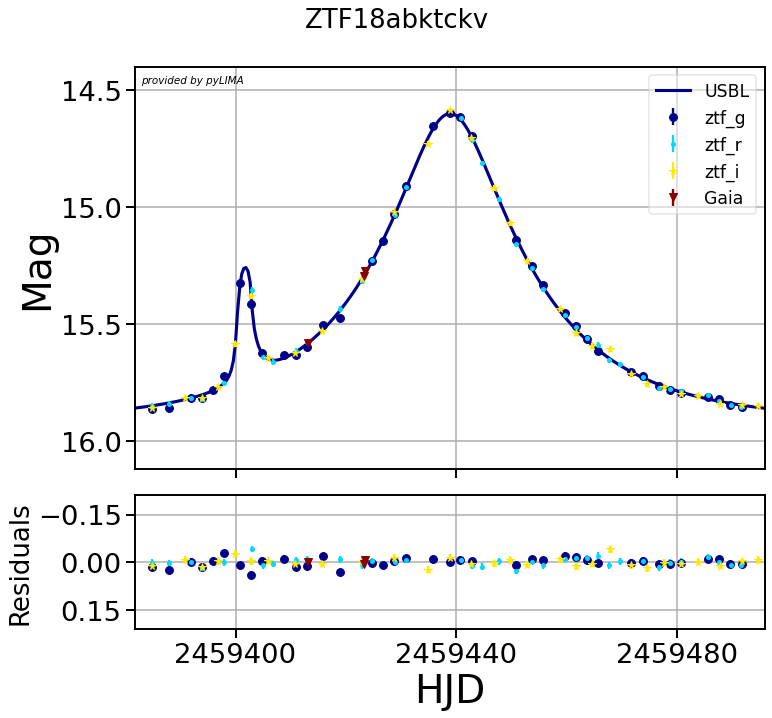

In [18]:
# pyLIMA magic
current_event = event.Event()
current_event.name = 'ZTF18abktckv'

current_event.ra = pdf_ZTF['ra'].values[0]
current_event.dec = pdf_ZTF['dec'].values[0]

filts = {'zg': 'g', 'zr': 'r', 'zi': 'i'}
for fid in ['zg','zr', 'zi']:
    mask = pdf_ZTF['filtercode'].values == fid
    telescope = telescopes.Telescope(
        name='ztf_{}'.format(filts[fid]),
        camera_filter=format(filts[fid]),
        light_curve_magnitude=np.transpose(
            [
                pdf_ZTF['mjd'].values[mask]+2400000.5,
                pdf_ZTF['mag'][mask],
                pdf_ZTF['magerr'][mask]
            ]
        ),
        light_curve_magnitude_dictionnary={
            'time': 0,
            'mag': 1,
            'err_mag': 2
        }
    )

    current_event.telescopes.append(telescope)

    
### Gaia
lightcurve = np.loadtxt('./Gaia.dat',dtype=str)

mask = (lightcurve[:,1]=='untrusted') |  (lightcurve[:,1]=='null')
lightcurve = lightcurve[~mask]
lightcurve = lightcurve[:,[0,1]].astype(float)
errors = [estimateGaiaError(i) for i in lightcurve[:,1]]
lightcurve = np.c_[lightcurve,errors]
telescope = telescopes.Telescope(
        name='Gaia',
        camera_filter='G',
        light_curve_magnitude=lightcurve
        )
current_event.telescopes.append(telescope)
    
    
# USBL model -- TRF
mulens_model = microlmodels.create_model('USBL', current_event)
mulens_model.parameters_guess = [2459438.8042624635, 0.28967950357242556, 28.54840874346009, 0.04989598439800191, 0.272393673849404, -2.8730822458911205, 0.23513925488422255-np.pi] 
current_event.fit(mulens_model, 'TRF')
current_event.fits[0].produce_outputs()
plt.show()    

# USBL model -- MCMC
# mulens_model = microlmodels.create_model('USBL', current_event)
# mulens_model.parameters_guess = [2459438.8042624635, 0.28967950357242556, 28.54840874346009, 0.04989598439800191, 0.272393673849404, -2.8730822458911205, 0.23513925488422255-np.pi] 
# current_event.fit(mulens_model, 'MCMC')

In [19]:
# current_event.fits[1].produce_outputs()
# plt.show()

In [20]:
# 7 parameters model (USBL)
dof = len(pdf_ZTF) - len(mulens_model.parameters_guess) - 1

results = current_event.fits[0]

normalised_lightcurves = microltoolbox.align_the_data_to_the_reference_telescope(
    results, 0, results.fit_results)

In [21]:
# Model
create_the_fake_telescopes(results, results.fit_results)

telescope_ = results.event.fake_telescopes[0]

flux_model = mulens_model.compute_the_microlensing_model(telescope_, results.model.compute_pyLIMA_parameters(results.fit_results))[0]

time = telescope_.lightcurve_flux[:, 0]
magnitude = microltoolbox.flux_to_magnitude(flux_model)

# fitted parameters
names = results.model.model_dictionnary
params = results.fit_results
err = np.diag(np.sqrt(results.fit_covariance))

In [23]:
l = []
for name in ['to', 'uo', 'tE', 'rho', 'logs', 'logq', 'alpha']:
    l.append(getattr(current_event.fits[0].outputs.fit_parameters, name))
print(l)

[2459438.8339372384, 0.2904106078775818, 28.559730843248033, 0.04991821311270513, 0.27258669341613, -2.8728000184977804, -2.906941213042617]


In [24]:
# restore default plot settings
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

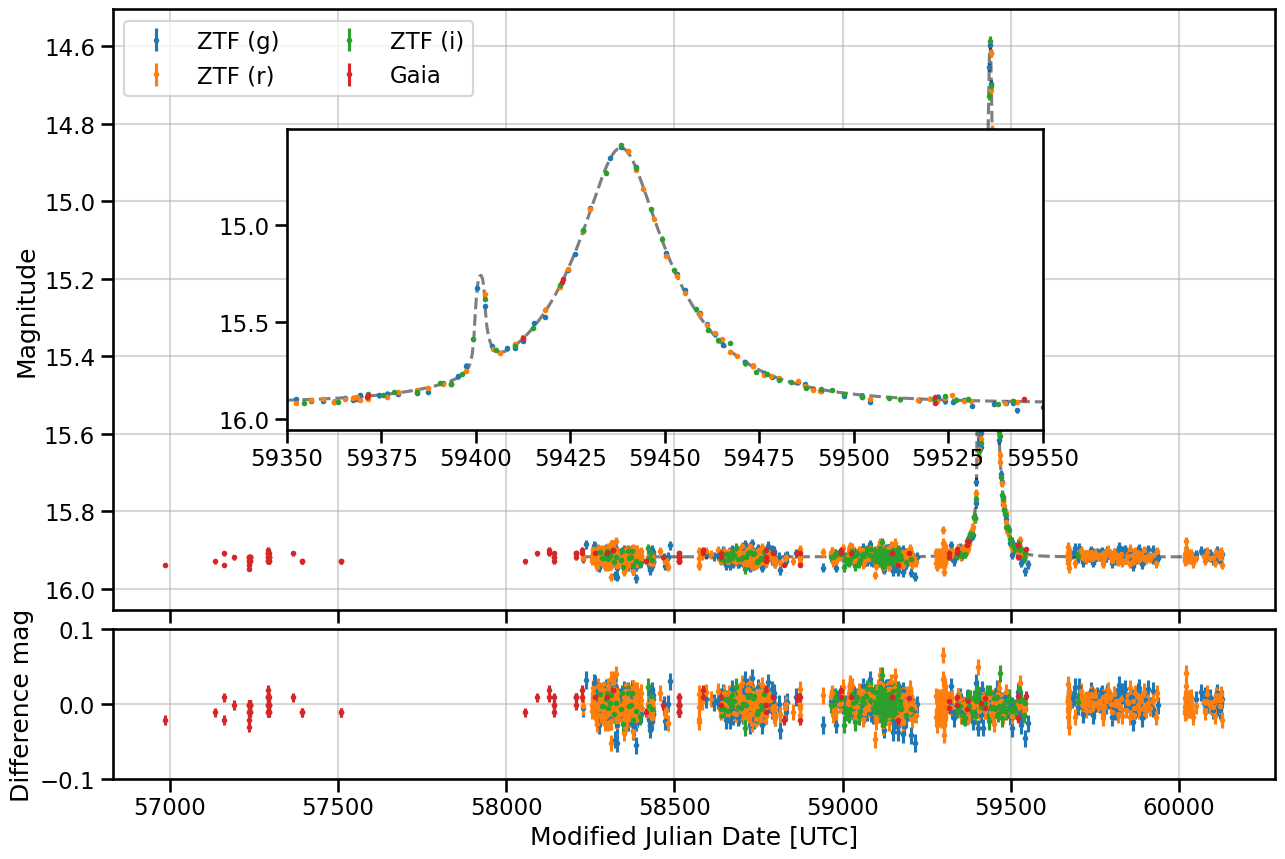

In [25]:
fig = plt.figure(figsize=(15, 10))

gs = GridSpec(2, 1, height_ratios=[4, 1], hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
axins = ax1.inset_axes([0.15, 0.3, 0.65, 0.5])

name_telescopes = ['ZTF (g)', 'ZTF (r)', 'ZTF (i)', 'Gaia']
# name_telescopes = ['ZTF (g)', 'ZTF (r)', 'ZTF (i)']

for ax in [ax1, axins]:
    for index, name in enumerate(name_telescopes):
        ax.errorbar(
            [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]],
            normalised_lightcurves[index][:, 1],
            normalised_lightcurves[index][:, 2],
            ls='',
            marker='o',
            markersize=3,
            label=name
        )

        if index == 0:
            ax.plot(
                *get_model(current_event),
                color='black', ls='--', alpha=0.5
            )
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('Magnitude');
ax1.invert_yaxis()
ax1.legend(ncol=2)
ax1.grid(alpha=0.5)

axins.set_xlim(59350, 59550)
axins.invert_yaxis()

t_model, mag_model = get_model(current_event)
for index, name in enumerate(name_telescopes):
    mag_inter = np.interp(
        [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]], 
        t_model, 
        mag_model
    )
    ax2.errorbar(
        [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]],
        mag_inter - normalised_lightcurves[index][:, 1],
        normalised_lightcurves[index][:, 2],
        ls='',
        marker='o',
        markersize=3,
        label=name
    )

ax2.grid(alpha=0.5)
ax2.set_xlabel('Modified Julian Date [UTC]');
ax2.set_ylim(-0.1, 0.1)
ax2.set_ylabel('Difference mag');

In [26]:
msg = """
# Fitted parameters
t0: {:.2f} +/- {:.2f} (MJD)
tE: {:.2f} +/- {:.2f} (days)
u0: {:.2f} +/- {:.2f}
rho: {:.2f} +/- {:.2f}
logs: {:.2f} +/- {:.2f}
logq: {:.2f} +/- {:.2f}
alpha: {:.2f} +/- {:.2f}
fs_ztf_g: {:.2f} +/- {:.2f}
g_ztf_g: {:.2f} +/- {:.2f}
fs_ztf_r: {:.2f} +/- {:.2f}
g_ztf_r: {:.2f} +/- {:.2f}
chi2/dof: {:.2f}
""".format(
    params[names['to']],
    err[names['to']],
    params[names['tE']],
    err[names['tE']],
    params[names['uo']],
    err[names['uo']],
    params[names['rho']],
    err[names['rho']],
    params[names['logs']],
    err[names['logs']],
    params[names['logq']],
    err[names['logq']],
    params[names['alpha']],
    err[names['alpha']],
    params[names['fs_ztf_g']],
    err[names['fs_ztf_g']],
    params[names['g_ztf_g']],
    err[names['g_ztf_g']],
    params[names['fs_ztf_r']],
    err[names['fs_ztf_r']],
    params[names['g_ztf_r']],
    err[names['g_ztf_r']],
    params[-1] / dof
)
print(msg)


# Fitted parameters
t0: 2459438.83 +/- 0.05 (MJD)
tE: 28.56 +/- 0.09 (days)
u0: 0.29 +/- 0.00
rho: 0.05 +/- 0.00
logs: 0.27 +/- 0.00
logq: -2.87 +/- 0.02
alpha: -2.91 +/- 0.00
fs_ztf_g: 36264.00 +/- 206.73
g_ztf_g: 0.08 +/- 0.01
fs_ztf_r: 57989.22 +/- 298.96
g_ztf_r: 0.12 +/- 0.01
chi2/dof: 1.32

